In [2]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import models, layers
from tensorflow.keras.models import load_model, Model
from ultralytics import YOLO

In [3]:
labels_df = pd.read_csv("data/labels.csv")
labels_df['id'] = labels_df['id'] + ".jpg" 
labels_df.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07.jpg,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97.jpg,dingo
2,001cdf01b096e06d78e9e5112d419397.jpg,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d.jpg,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62.jpg,golden_retriever


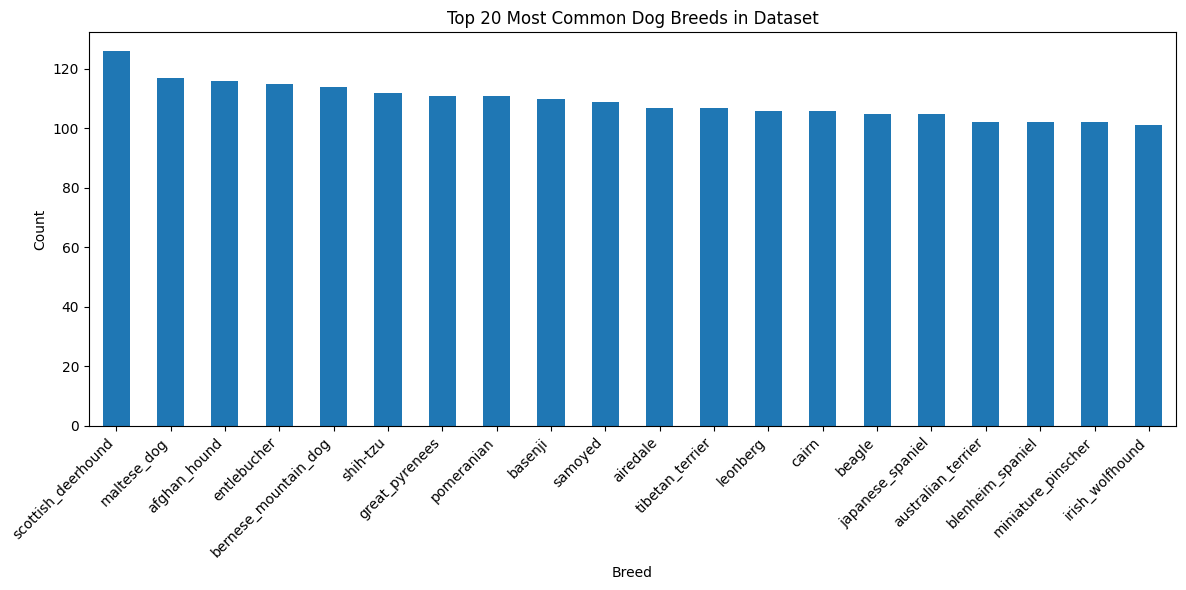

In [4]:
breed_counts = labels_df['breed'].value_counts()

plt.figure(figsize=(12, 6))
breed_counts.head(20).plot(kind='bar')
plt.title("Top 20 Most Common Dog Breeds in Dataset")
plt.xlabel("Breed")
plt.ylabel("Count")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig("top_20_breeds.png")

plt.show()

In [5]:
train_df, temp_df = train_test_split(labels_df, test_size=0.3, stratify=labels_df['breed'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['breed'], random_state=42)


In [6]:
print(f"Dataset loaded: {labels_df.shape[0]} samples, {labels_df['breed'].nunique()} breeds")

train_df, temp_df = train_test_split(
    labels_df, 
    test_size=0.3, 
    stratify=labels_df['breed'], 
    random_state=42
)
val_df, test_df = train_test_split(
    temp_df, 
    test_size=0.5, 
    stratify=temp_df['breed'], 
    random_state=42
)

print(f"Data split - Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

SIZE = (350, 350)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

image_dir = "data/train/"

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=image_dir,
    x_col='id',
    y_col='breed',
    target_size=SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=image_dir,
    x_col='id',
    y_col='breed',
    target_size=SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=image_dir,
    x_col='id',
    y_col='breed',
    target_size=SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

def create_model(num_classes):
    base_model = Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(350, 350, 3)
    )
    
    base_model.trainable = False
    
    model = models.Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dropout(0.3),
        Dense(512, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    
    return model

model = create_model(len(train_generator.class_indices))
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


Dataset loaded: 10222 samples, 120 breeds
Data split - Train: 7155, Val: 1533, Test: 1534
Found 7155 validated image filenames belonging to 120 classes.
Found 1533 validated image filenames belonging to 120 classes.
Found 1534 validated image filenames belonging to 120 classes.
Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



In [7]:
early_stopping = EarlyStopping(monitor='val_loss', patience=4, verbose=1)
model_checkpoint = ModelCheckpoint('model.keras', monitor='val_loss', save_best_only=True, verbose=1)

In [8]:
history = model.fit(train_generator,
                    validation_data=val_generator,
                    steps_per_epoch=train_generator.samples//BATCH_SIZE,
                    validation_steps=val_generator.samples//BATCH_SIZE,
                    epochs=12,
                    callbacks=[early_stopping, model_checkpoint])

Epoch 1/12
223/223 [==============================] - ETA: 0s - loss: 1.5223 - accuracy: 0.6583
Epoch 1: val_loss improved from inf to 0.40886, saving model to model.keras
223/223 [==============================] - 372s 2s/step - loss: 1.5223 - accuracy: 0.6583 - val_loss: 0.4089 - val_accuracy: 0.8823
Epoch 2/12
223/223 [==============================] - ETA: 0s - loss: 0.5522 - accuracy: 0.8291
Epoch 2: val_loss improved from 0.40886 to 0.36120, saving model to model.keras
223/223 [==============================] - 500s 2s/step - loss: 0.5522 - accuracy: 0.8291 - val_loss: 0.3612 - val_accuracy: 0.8850
Epoch 3/12
223/223 [==============================] - ETA: 0s - loss: 0.4649 - accuracy: 0.8539
Epoch 3: val_loss improved from 0.36120 to 0.33142, saving model to model.keras
223/223 [==============================] - 465s 2s/step - loss: 0.4649 - accuracy: 0.8539 - val_loss: 0.3314 - val_accuracy: 0.8910
Epoch 4/12
223/223 [==============================] - ETA: 0s - loss: 0.4119 - a

In [10]:
test_loss, test_accuracy = model.evaluate(test_generator)
print("Test loss:", test_loss)
print("Test accuracy:", test_accuracy)

48/48 [==============================] - 57s 1s/step - loss: 0.3621 - accuracy: 0.8924
Test loss: 0.3620870113372803
Test accuracy: 0.8924380540847778


In [11]:
y_pred = model.predict(test_generator, verbose=0)
y_pred_indices = np.argmax(y_pred, axis=1)
idx_to_class = {v: k for k, v in test_generator.class_indices.items()}

results_df = pd.DataFrame({
    "imageID": test_generator.filenames,
    "predicted_class": [idx_to_class[i] for i in y_pred_indices],
    "actual_class": [idx_to_class[i] for i in test_generator.classes],
})
results_df.head()


,imageID,predicted_class,actual_class
0,c6ab645e969263618b547ff66fd19d1f.jpg,brabancon_griffon,brabancon_griffon
1,66b1a3eb90d750b8739cbd6e74db13cf.jpg,gordon_setter,gordon_setter
2,12fe7ed6bd250509b131d245551b06f6.jpg,tibetan_terrier,tibetan_terrier
3,4b691c6936f4292697c85683f6a35aad.jpg,bluetick,bluetick
4,520b060d394dc47785d2eef1b627b895.jpg,briard,briard


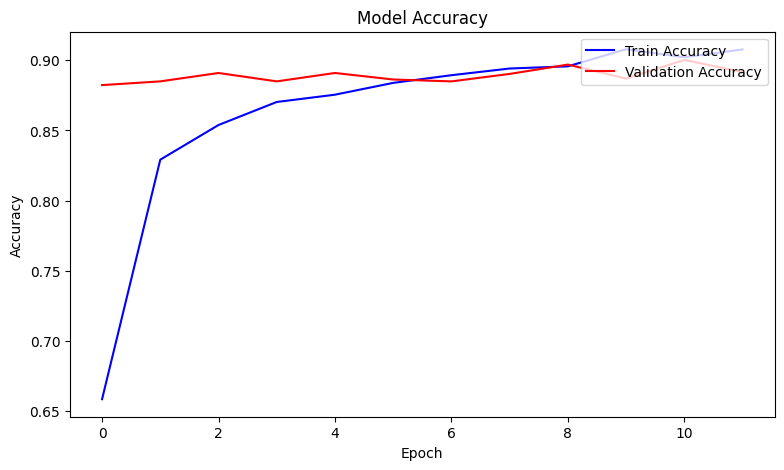

In [12]:
plt.figure(figsize=(20, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper right')


plt.show()

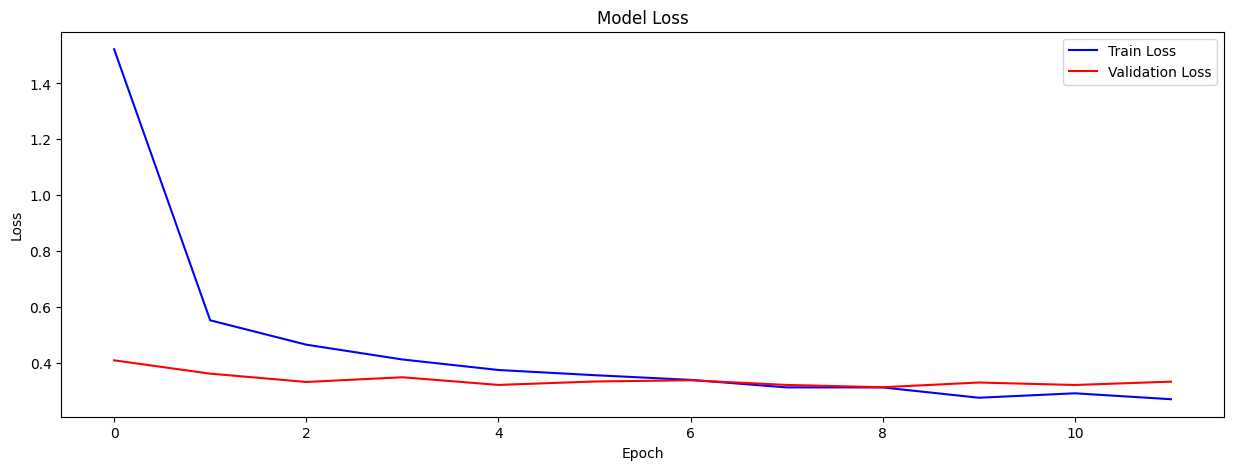

In [13]:
plt.figure(figsize=(15, 5))
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

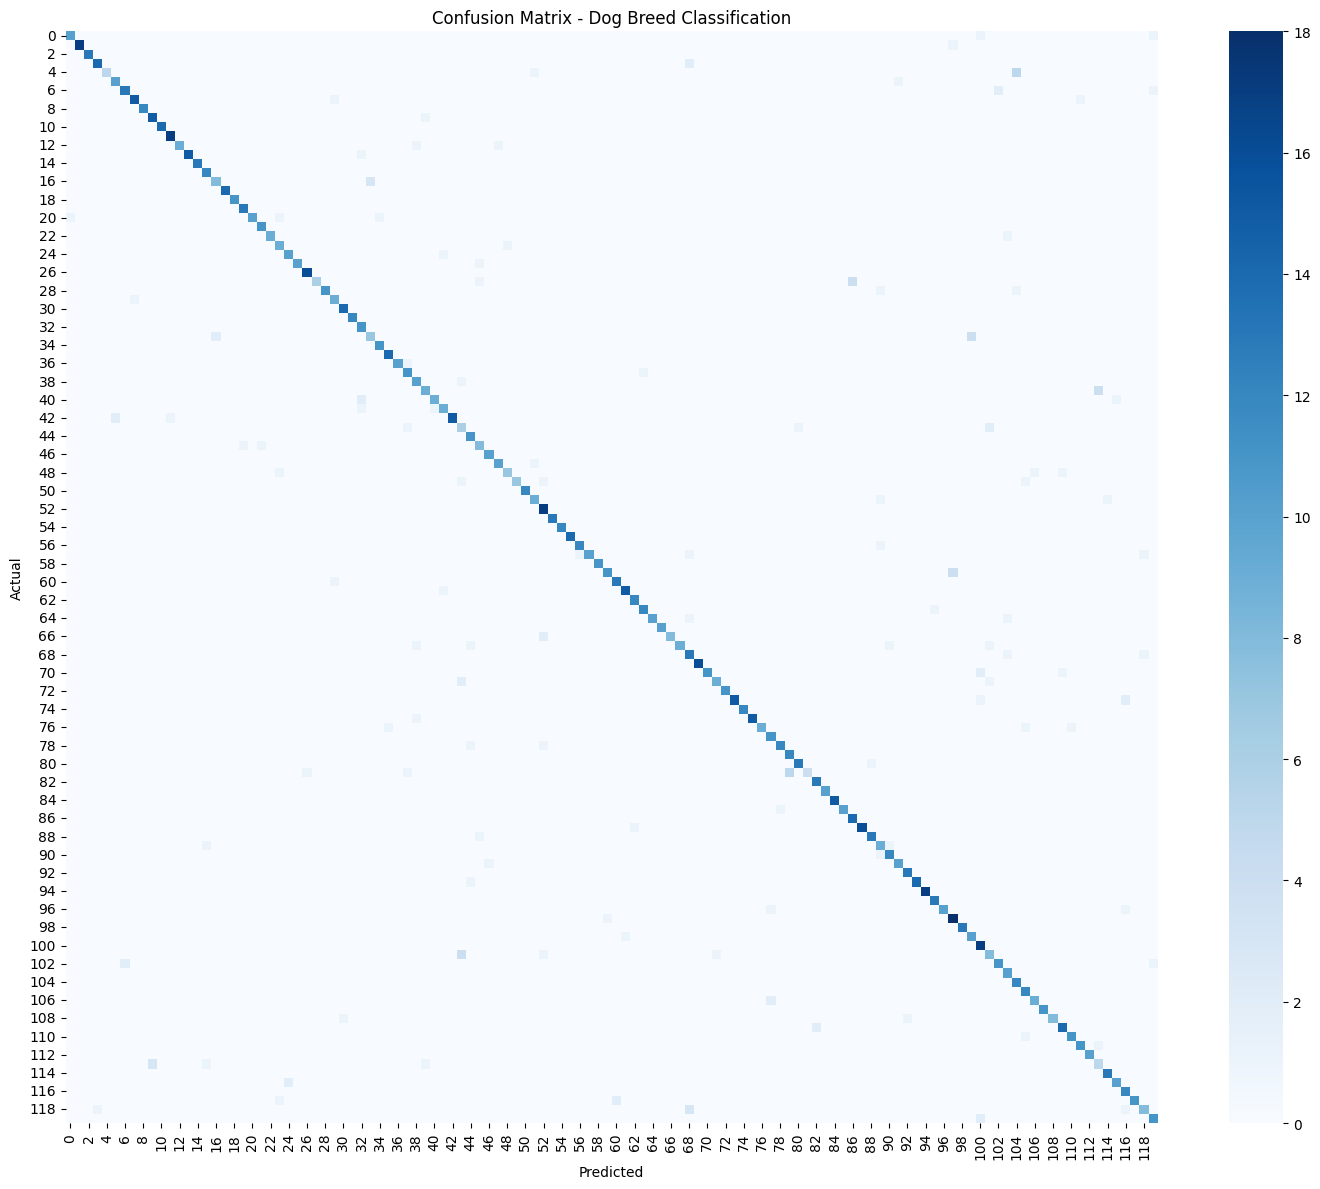

Test Accuracy: 0.8924
Total test samples: 1534
Number of classes: 120


In [14]:
test_generator.reset()
y_true = []
y_pred = []

for i in range(len(test_generator)):
    x_batch, y_batch = next(test_generator)
    pred_batch = model.predict(x_batch, verbose=0)
    y_true.extend(np.argmax(y_batch, axis=1))
    y_pred.extend(np.argmax(pred_batch, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

cm = confusion_matrix(y_true, y_pred)

class_names = list(test_generator.class_indices.keys())

plt.figure(figsize=(15, 12))
sns.heatmap(cm,annot=False,cmap='Blues',square=True)

plt.title('Confusion Matrix - Dog Breed Classification')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

accuracy = np.sum(y_true == y_pred) / len(y_true)
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Total test samples: {len(y_true)}")
print(f"Number of classes: {len(class_names)}")


Predictions for doggie.jpg:
----------------------------------------
1. Golden Retriever: 99.93%
2. Flat-Coated Retriever: 0.02%
3. Newfoundland: 0.01%
4. Great Pyrenees: 0.01%
5. Redbone: 0.01%


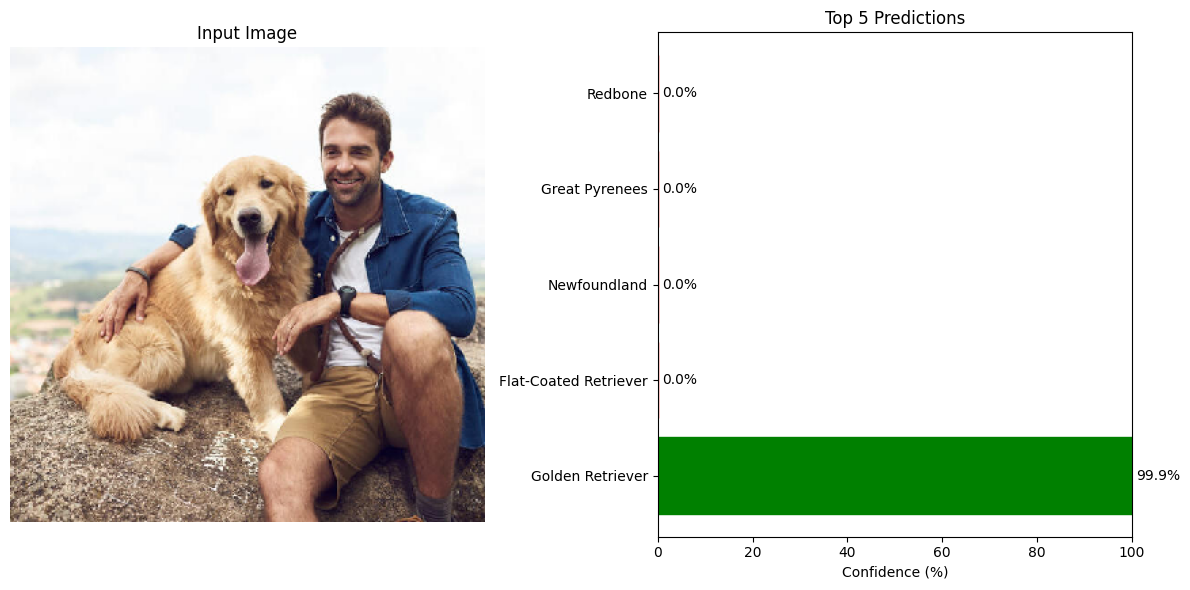

In [15]:
def predict_dog_breed(model, img_path, class_indices, top_k=5):
    idx_to_class = {v: k for k, v in class_indices.items()}
    
    try:
        img = image.load_img(img_path, target_size=(350, 350))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = img_array / 255.0

        predictions = model.predict(img_array, verbose=0)
        
        top_indices = np.argsort(predictions[0])[::-1][:top_k]
        top_predictions = []
        
        for i in top_indices:
            breed = idx_to_class[i]
            confidence = predictions[0][i] * 100
            top_predictions.append((breed, confidence))
        
        return top_predictions, img
        
    except Exception as e:
        print(f"Error processing image: {e}")
        return None, None

def visualize_prediction(img_path, predictions, img):
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title('Input Image')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    breeds = [pred[0].replace('_', ' ').title() for pred in predictions]
    confidences = [pred[1] for pred in predictions]
    
    y_pos = np.arange(len(breeds))
    bars = plt.barh(y_pos, confidences)

    for i, bar in enumerate(bars):
        if confidences[i] > 50:
            bar.set_color('green')
        elif confidences[i] > 20:
            bar.set_color('orange')
        else:
            bar.set_color('red')
    
    plt.yticks(y_pos, breeds)
    plt.xlabel('Confidence (%)')
    plt.title('Top 5 Predictions')
    plt.xlim(0, 100)
    
    for i, v in enumerate(confidences):
        plt.text(v + 1, i, f'{v:.1f}%', va='center')
    
    plt.tight_layout()
    plt.show()

img_path = 'doggie.jpg'
predictions, img = predict_dog_breed(model, img_path, train_generator.class_indices)

if predictions:
    print(f"\nPredictions for {img_path}:")
    print("-" * 40)
    for i, (breed, confidence) in enumerate(predictions, 1):
        breed_name = breed.replace('_', ' ').title()
        print(f"{i}. {breed_name}: {confidence:.2f}%")
    
    visualize_prediction(img_path, predictions, img)
else:
    print("Failed to make prediction. Check your image path.")


Predictions for doggie.jpg
----------------------------------------
1. Golden Retriever               : 99.95%
2. Flat-Coated Retriever          : 0.03%
3. Newfoundland                   : 0.00%
4. Leonberg                       : 0.00%
5. Pekinese                       : 0.00%


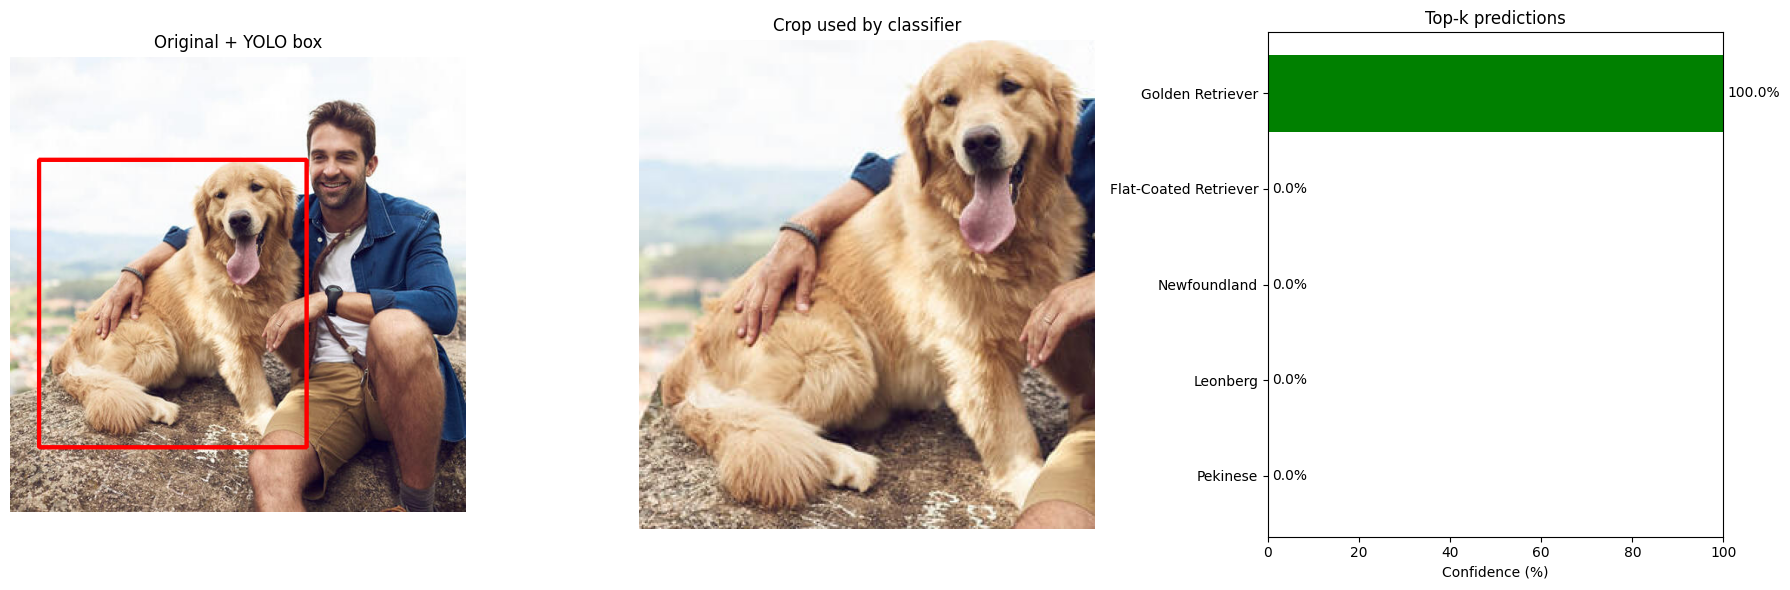

In [16]:
DET_MODEL = YOLO("yolov8n.pt")
CLF_MODEL = model
IDX2CLASS = {v: k for k, v in train_generator.class_indices.items()}
IMG_SIZE  = (350, 350)

def crop_dog(img_path, conf_thresh=0.25):
    results = DET_MODEL(img_path, conf=conf_thresh, verbose=False)[0]
    dog_boxes = [b for b in results.boxes.data.cpu().numpy() if int(b[5]) == 16]
    if not dog_boxes:
        return None, None
    x1, y1, x2, y2, conf, _cls = dog_boxes[np.argmax([b[4] for b in dog_boxes])]
    img = Image.open(img_path).convert("RGB")
    crop_pil = img.crop((int(x1), int(y1), int(x2), int(y2)))
    return crop_pil, (int(x1), int(y1), int(x2), int(y2))

def preprocess_pil(pil_img):
    pil_img = pil_img.resize(IMG_SIZE, Image.Resampling.LANCZOS)
    arr= image.img_to_array(pil_img) / 255.0
    return np.expand_dims(arr, axis=0)

def predict_with_yolo(img_path, top_k=5):
    crop_pil, box = crop_dog(img_path)
    used_pil= crop_pil if crop_pil is not None else Image.open(img_path).convert("RGB")
    x = preprocess_pil(used_pil)
    preds= CLF_MODEL.predict(x, verbose=0)[0]
    top_idx = preds.argsort()[::-1][:top_k]
    top_pairs = [(IDX2CLASS[i], float(preds[i] * 100)) for i in top_idx]
    return top_pairs, used_pil, box

def visualize_full(img_path, preds, crop_img, box):
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    
    orig = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    if box:
        cv2.rectangle(orig, (box[0], box[1]), (box[2], box[3]), (255, 0, 0), 3)
    axs[0].imshow(orig); axs[0].set_title("Original + YOLO box"); axs[0].axis("off")
    
    axs[1].imshow(crop_img); axs[1].set_title("Crop used by classifier"); axs[1].axis("off")
    
    breeds= [b.replace("_", " ").title() for b, _ in preds]
    confidences= [c for _, c in preds]
    y_pos= np.arange(len(breeds))
    bars = axs[2].barh(y_pos, confidences, color=["green" if c > 50 else "orange" if c > 20 else "red" for c in confidences])
    axs[2].set_yticks(y_pos); axs[2].set_yticklabels(breeds)
    axs[2].invert_yaxis()
    axs[2].set_xlim(0, 100)
    axs[2].set_xlabel("Confidence (%)")
    axs[2].set_title("Top-k predictions")
    for i, v in enumerate(confidences):
        axs[2].text(v + 1, i, f"{v:.1f}%", va="center")
        
    plt.tight_layout(); plt.show()

img_path = "doggie.jpg"
preds, crop, bbox = predict_with_yolo(img_path, top_k=5)

print(f"\nPredictions for {img_path}")
print("-" * 40)
for i, (breed, conf) in enumerate(preds, 1):
    print(f"{i}. {breed.replace('_',' ').title():30s} : {conf:.2f}%")

visualize_full(img_path, preds, crop, bbox)


In [17]:
LABEL_CSV = "data/labels.csv"
IMG_DIR   = "data/train"
CLF_PATH  = "model.keras"
IMG_SIZE  = (350, 350)
DETECTOR  = YOLO("yolov8n.pt")

labels = pd.read_csv(LABEL_CSV)
if not labels["id"].iloc[0].endswith(".jpg"):
    labels["id"] += ".jpg"

_, tmp  = train_test_split(labels,test_size=0.30,stratify=labels["breed"], random_state=42)
_, test = train_test_split(tmp,test_size=0.50,stratify=tmp["breed"], random_state=42)

def preprocess_pil(pil_img):
    pil_img = pil_img.resize(IMG_SIZE, Image.Resampling.LANCZOS)
    arr     = image.img_to_array(pil_img) / 255.0
    return np.expand_dims(arr, 0)

clf_model = load_model(CLF_PATH)
conf_fullframe = []
conf_with_crop = []

for img_name in test["id"]:
    path = os.path.join(IMG_DIR, img_name)
    pil  = Image.open(path).convert("RGB")
    p_full = clf_model.predict(preprocess_pil(pil), verbose=0)[0]
    conf_fullframe.append(p_full.max() * 100)
    res = DETECTOR(path, conf=0.25, verbose=False)[0]
    dog_boxes = [b for b in res.boxes.data.cpu().numpy() if int(b[5]) == 16]

    if dog_boxes:
        x1, y1, x2, y2, *_ = dog_boxes[np.argmax([b[4] for b in dog_boxes])]
        crop= pil.crop((int(x1), int(y1), int(x2), int(y2)))
        p_crop   = clf_model.predict(preprocess_pil(crop), verbose=0)[0]
        conf_with_crop.append(p_crop.max() * 100)
    else:
        conf_with_crop.append(conf_fullframe[-1])

df = pd.DataFrame({
    "image": test["id"].tolist(),
    "conf_fullframe": conf_fullframe,
    "conf_with_crop": conf_with_crop,
    "delta": np.array(conf_with_crop) - np.array(conf_fullframe)
})
df.to_csv("confidence_comparison_xception.csv", index=False)
print("Saved per-image results ➜ confidence_comparison_xception.csv")

mean_full = np.mean(conf_fullframe)
mean_crop = np.mean(conf_with_crop)

print(f"\nMean top-1 confidence")
print(f" • Full frame : {mean_full:6.2f} %")
print(f" • YOLO crop  : {mean_crop:6.2f} %")
print(f" • Difference : {mean_crop - mean_full:+6.2f} %")

plt.figure(figsize=(8,5))
plt.hist(conf_fullframe, bins=20, alpha=0.6, label="Full frame")
plt.hist(conf_with_crop, bins=20, alpha=0.6, label="YOLO crop")
plt.xlabel("Top-1 confidence (%)"); plt.ylabel("Frequency")
plt.title("Confidence distribution on test set (Xception)")
plt.legend(); plt.tight_layout()
plt.savefig("confidence_hist_xception.png"); plt.close()
print("Saved histogram ➜ confidence_hist_xception.png")


Saved per-image results ➜ confidence_comparison_xception.csv

Mean top-1 confidence
 • Full frame :  91.31 %
 • YOLO crop  :  91.02 %
 • Difference :  -0.30 %
Saved histogram ➜ confidence_hist_xception.png


In [26]:
results_df.to_csv('model_predictions5Epoch.csv', index=False)